# B1: Songbird Vocalization

The B1 dataset focuses on the continuous reconstruction of vocal output (song) from neural activity. 

The B1 dataset contains threshold crossings (Tx), audio recordings and audio spectrograms from a zebra finch songbird engaged in unconstrained vocal behavior (awake-singing). Neural activity was recorded using a single Neuropixels 1.0 probe implanted in the motor region robust nucleus of the arcopallium (RA). The dataset includes the synchronous raw amplitude waveform corresponding to individual renditions of song motifs segmented from the continuous experimental recordings. A precomputed spectrogram derived from the recorded amplitude waveform corresponding to each vocal epoch is also included, which constitutes the decoding target for this dataset.

<img src="imgs/b1.png" alt="title" width="250"/>

# Task 
An adult, male zebra finch songbird was implanted with a single high-density Neuropixels 1.0 probe targeting the telencephalic motor region RA in the right brain hemisphere. Simultaneous neural and behavioral (song) data were collected in a single-housing acoustically-isolated chamber during awake-singing. The bird was allowed to move and sing freely during 120-240 minute-long recording sessions.

# Use in FALCON
This dataset has been curated for evaluating stable decoding approaches as part of the FALCON benchmark. The dataset offers an alternative to brain-to-text iBCIs by focusing on the direct reconstruction of audio spectrograms from neural signals, thereby encouraging decoding approaches that preserve the prosodic elements of vocal behavior. The B1 dataset proposes the songbird model as a proxy for human vocalization, supporting the development of neuroprostheses aimed at restoring communication capabilities and advancing stable-decoding methods.

### Imports

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

import torch

from pynwb import NWBHDF5IO

# From falcon-challenge repository
try:
    from data_demos.visualizations import plot_split_bars, plot_timeline
    data_dir = Path("./data/001046/")
except ImportError:
    from visualization import plot_split_bars, plot_timeline
    data_dir = Path("../data/001046/")

# From EnSongdec
from ensongdec.utils.evaluation_utils import load_experiment_metadata, load_model, generate_original_and_reconstructed_audio, generate_trialized_original_and_reconstructed_audio
from ensongdec.evaluation_falcon import prepare_eval_dataloader_from_nwb

# b1 FALCON metrics
from preproc.b1_nwb_utils import load_nwb_b1
from preproc.b1_nwb_utils import compute_falcon_spectrogram
from sklearn.metrics import mean_squared_error

### Data Splits

Sessions `2021-06-26`, `2021-06-27` and `2021-06-28` are `held_in` sessions used to train the seed model decoder. 

Sessions `2021-06-30`, `2021-07-01` and `2021-07-05` are `held_out` sessions to evaluate the stability of the seed decoder and benchmark few-shot fine-tuning stategies for mitigating nonstationarity.

In [10]:
held_in_filepath = Path(data_dir / 'sub-Finch-z-r12r13-21-held-in-calib')
held_out_filepath = Path(data_dir / 'sub-Finch-z-r12r13-21-held-out-calib')

held_in_files = sorted(held_in_filepath.glob('*.nwb'))
held_out_files = sorted(held_out_filepath.glob('*.nwb'))

In [4]:
def get_start_date_and_volume(nwb_file_path_calib: Path):
    with NWBHDF5IO(nwb_file_path_calib, "r") as io:
        nwbfile = io.read()
        start_date = nwbfile.session_start_time.strftime('%Y-%m-%d')
        spike_times = np.array(nwbfile.get_acquisition('tx').timestamps)
        
    return pd.to_datetime(start_date), spike_times.shape[0]

fs_neural, fs_audio = int(load_nwb_b1(held_in_files[0])[2]), int(load_nwb_b1(held_in_files[0])[-1])

start_dates, volume = zip(*[get_start_date_and_volume(fn) for fn in held_in_files + held_out_files])
split_type = ['Held In'] * len(held_in_files) + ['Held Out'] * len(held_out_files) 

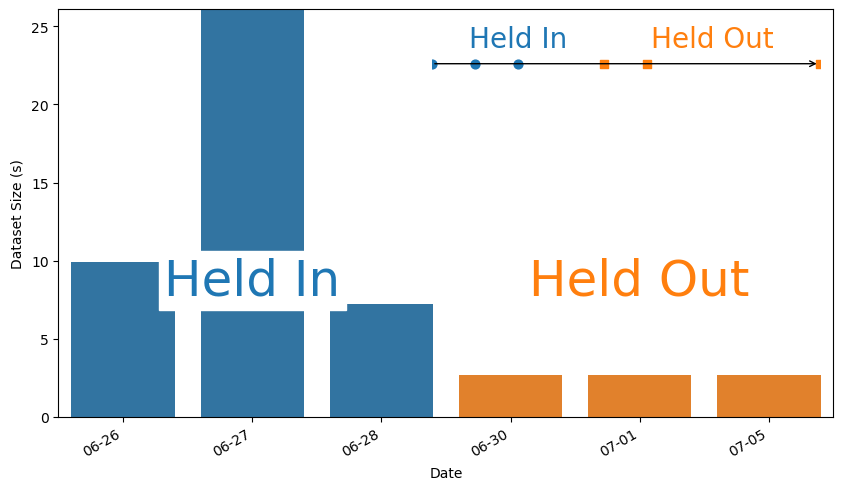

In [5]:
BIN_SIZE_S = 1/fs_neural
fig, ax = plt.subplots(figsize=(10, 6))

df = pd.DataFrame({'Date_Full': start_dates, 'Dataset Size': volume, 'Split Type': split_type})
# just get month and day
df['Dataset Size (s)'] = df['Dataset Size'] * BIN_SIZE_S
df['Date'] = df['Date_Full'].dt.strftime('%m-%d')

plot_split_bars(df, fig, ax)
sections = df.groupby(
    'Split Type'
)['Date'].apply(list).to_dict()
# sort section by section name, respect Train, Test Short, Test Long order
sections = {k: v for k, v in sorted(sections.items(), key=lambda item: item[1])}
plot_timeline(ax, sections)

# Inspect Data - Single NWB

In [6]:
# Load single NWB file
trial_info, neural_array, fs_neural, audio_motifs, fs_audio = load_nwb_b1(held_in_files[1])

### Plot all trials (Tx) for a given channel

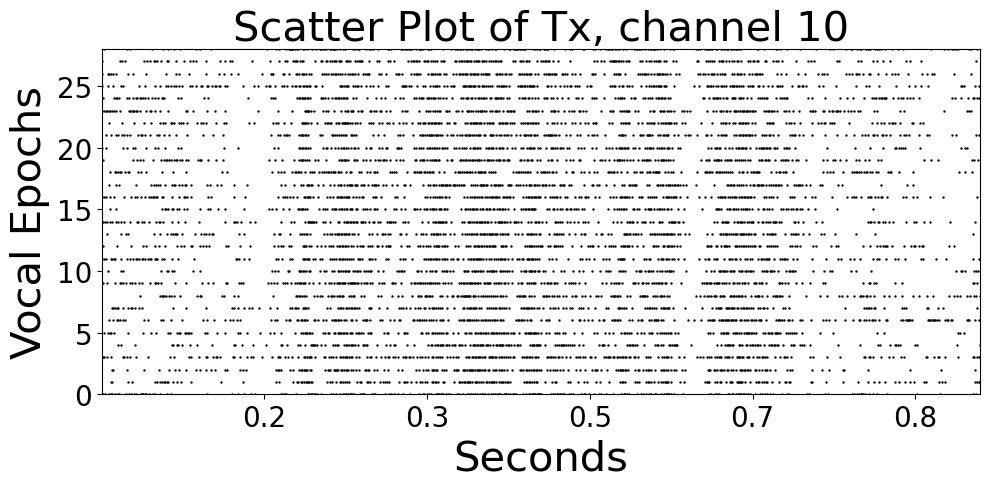

In [7]:
channel = 10
data = neural_array[:, channel, :]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Iterate over each channel
for channel_index, channel_data in enumerate(data):
    # Find indices where there is a 1
    event_indices = np.where(channel_data == 1)[0]
    plt.scatter(event_indices, np.full(event_indices.shape, channel_index), color='black', marker='.', s=2)

# Set the labels and title
plt.title(f'Scatter Plot of Tx, channel {channel}', fontsize=30)

# Set y-ticks only every 5 channels
plt.yticks(range(0, data.shape[0], 5), fontsize=20)
plt.ylabel('Vocal Epochs', fontsize=30)

# Set x-tick labels to seconds
locs, labels = plt.xticks()  # Get current locations and labels
new_labels = [f"{loc/fs_neural:.1f}" if loc != 0 else "0" for loc in locs]
plt.xticks(locs, new_labels, fontsize=20) 
plt.xlabel('Seconds', fontsize=30) 
ax.margins(x=0)

plt.tight_layout()

### Plot Tx for a given trial

In [8]:
trial_idx = 3

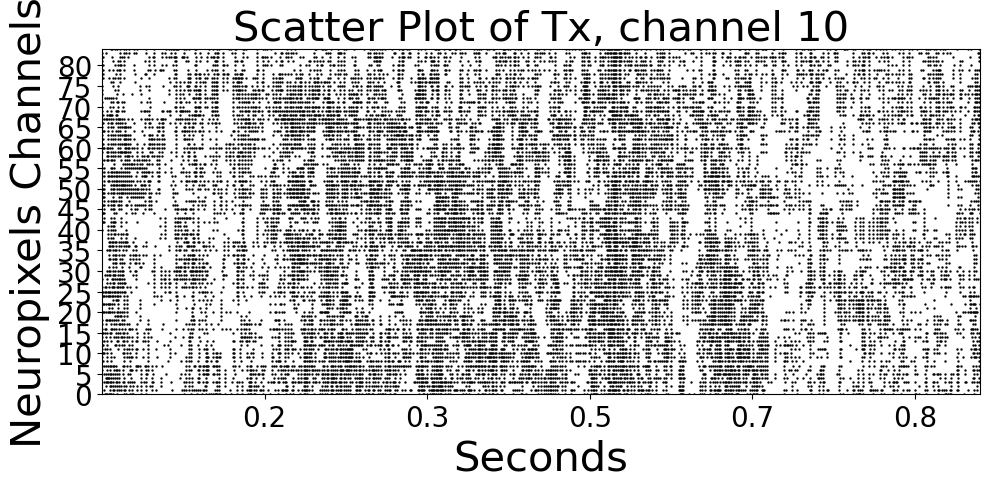

In [9]:
data = neural_array[trial_idx, :, :]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Iterate over each channel
for channel_index, channel_data in enumerate(data):
    # Find indices where there is a 1
    event_indices = np.where(channel_data == 1)[0]
    plt.scatter(event_indices, np.full(event_indices.shape, channel_index), color='black', marker='.', s=2)

# Set the labels and title
plt.title(f'Scatter Plot of Tx, channel {channel}', fontsize=30)

# Set y-ticks only every 5 channels
plt.yticks(range(0, data.shape[0], 5), fontsize=20)
plt.ylabel('Neuropixels Channels', fontsize=30)

# Set x-tick labels to seconds
locs, labels = plt.xticks()  # Get current locations and labels
new_labels = [f"{loc/fs_neural:.1f}" if loc != 0 else "0" for loc in locs]
plt.xticks(locs, new_labels, fontsize=20) 
plt.xlabel('Seconds', fontsize=30) 
ax.margins(x=0)

plt.tight_layout()

### Plot Amplitude Waveform and spectrogram

Text(0, 0.5, 'Freq.')

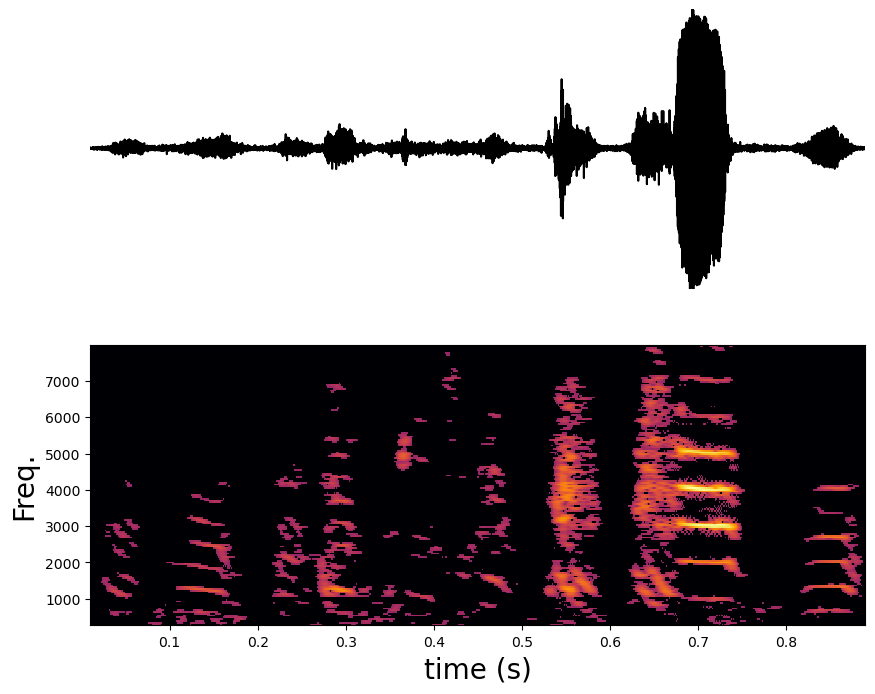

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Amplitude Waveform
ax1.plot(audio_motifs[trial_idx], 'k')
ax1.axis('off') 
ax1.margins(x=0)

# Spectrogram
t = trial_info['spectrogram_times'][trial_idx]
f = trial_info['spectrogram_frequencies'][trial_idx]
sxx = trial_info['spectrogram_values'][trial_idx]

ax2.pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax2.set_xlabel('time (s)', fontsize=20)
ax2.set_ylabel('Freq.', fontsize=20)

# Evaluating EnSongdec decoders

The FALCON benchmark measures decoding performance from neural data. Here we provide an EnSongdec-centric baseline to predict vocal outputs from Tx. 

*The evaluation on eval data will run on EvalAI. Here, we show evaluation results using relative filepaths for demonstration purposes.

In [11]:
def normalize_signal(x):
    """"
    Normalizes signal x between 0 and 1.
    """
    return (x-np.min(x))/(np.max(x)-np.min(x))


def evaluate_ensongdec_model(model_timestamp, nwb_eval_file_path, model_extension):
    print(f'Evaluating {model_timestamp} on {nwb_eval_file_path}')
    
    # Filter files based on the extension
    model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
    
    # Load models CSV info file
    info_path = os.path.join(models_checkpoints_dir, 'models_info.csv')
    
    # Check if the file exists and 
    if os.path.isfile(info_path):
        df_models = pd.read_csv(info_path)
    
    df_models['tot_val_err'] = df_models['tot_val_err'].apply(ast.literal_eval)
    df_models['tot_train_err'] = df_models['tot_train_err'].apply(ast.literal_eval)
    
    # --------- LOCATE MODEL and EXPERIMENT METADATA --------- #
    model_filename = next((file for file in os.listdir(models_checkpoints_dir) if model_timestamp in file and file.endswith(model_extension)), None)
    experiment_metadata = load_experiment_metadata(models_checkpoints_dir, model_filename)
    
    # --------- LOAD MODEL, OPTIMIZER STATE DICT & EVAL DATALOADER --------- #
    print('Loading model: ', model_filename)
    model_layers = experiment_metadata['layers']
    learning_rate = experiment_metadata["learning_rate"]
    ffnn_model, optimizer = load_model(models_checkpoints_dir, model_filename, model_layers, learning_rate)
    
    trial_info, neural_array, fs_neural, audio_motifs, fs_audio = load_nwb_b1(nwb_eval_file_path)
    test_dataset, test_loader, fs_audio, encodec_model, scales = prepare_eval_dataloader_from_nwb(models_checkpoints_dir, model_filename, nwb_eval_file_path)
    
    # --------- PREDICT AMPLITUDE WAVEFORM --------- #
    num_trials = len(trial_info)
    scale = torch.mean(scales)
    original_audio, reconstructed_audio = generate_trialized_original_and_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale, num_trials)
    
    # --------- PAD AUDIO WAVEFORM --------- #
    # In our decoding strategy, the use of ~14ms of neural history results into a shorter reconstructed waveform than the original trials.
    # This shortening happens at the beginning of the trial, where there is no history of neural data to predict vocal output.
    # Since this section of the waveform lies in the first 100ms that will be ommited by the eval_mask anyways, we pad it with zeros.
    
    # Pad the beginning of each row with zeros
    pad_length = audio_motifs.shape[-1] - reconstructed_audio.shape[-1]
    padded_reconstructed_audio = np.pad(reconstructed_audio, ((0, 0), (pad_length, 0)), mode='constant', constant_values=0)
    
    # --------- COMPUTE RECONSTRUCTED SPECTROGRAMS --------- #
    reconstructed_sxx = np.array([compute_falcon_spectrogram(padded_reconstructed_audio[idx], fs_audio)[-1] for idx in range(len(padded_reconstructed_audio))])
    
    # --------- CALCULATE RECONSTRUCTION ERROR --------- #
    # !Mask applied according to evaluation criteria
    
    error_per_trial = []
    for trial_idx in range(len(trial_info)):
        sxx_eval_mask = trial_info['spectrogram_eval_mask'][trial_idx]
        
        original_sxx_masked = trial_info['spectrogram_values'][trial_idx] * sxx_eval_mask
        reconstructed_sxx_masked = reconstructed_sxx[trial_idx] * sxx_eval_mask
    
        # Calculate spectrogram reconstruction error
        error_per_trial.append(mean_squared_error(normalize_signal(original_sxx_masked), normalize_signal(reconstructed_sxx_masked)))
    
    return error_per_trial, original_sxx_masked, reconstructed_sxx_masked

### Single-day evaluation

Evaluating z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705 on /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.27_held_in_eval.nwb
Loading z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705_metadata.json
Loading model:  z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705.pt
Loading z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705_metadata.json
Length of neural trials: 900.0 ms, length of audio trials: 900.0 ms. 
Neural array shape (18, 85, 135), Audio embeddings shape torch.Size([18, 128, 135]).
Using 2 bins of neural data history for decoding.
Dataset and Dataloader created. Samples: 2394
Mean reconstruction error in /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.27_held_in_eval.nwb = 0.00041212345620662735


/tmp/ipykernel_2138/756632422.py:25: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(t, f, np.log(original_sxx_masked), cmap='inferno')
/tmp/ipykernel_2138/756632422.py:32: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(t, f, np.log(reconstructed_sxx_masked), cmap='inferno')


Text(0, 0.5, 'Freq.')

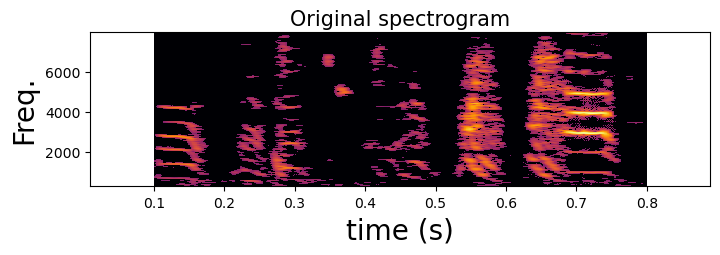

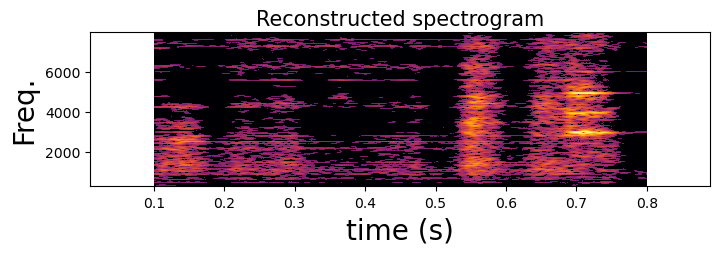

In [12]:
# Paths of interest
models_checkpoints_dir = '/path_to/ensongdec/models_checkpoints/'
model_extension = '.pt'

eval_models = [
    {
        'model_timestamp': 'z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705',
        'nwb_eval_file_path': '/data_b1/nwb_files/z_r12r13_21_2021.06.27_held_in_eval.nwb'  
    }
]

ensongdec_model = eval_models[0]
ensongdec_model_ts = ensongdec_model['model_timestamp']
nwb_eval_file_path = ensongdec_model['nwb_eval_file_path']

error_per_trial, original_sxx_masked, reconstructed_sxx_masked = evaluate_ensongdec_model(ensongdec_model_ts, nwb_eval_file_path, model_extension)
print(f'Mean reconstruction error in {nwb_eval_file_path} = {np.mean(error_per_trial)}')

# Example of an original vs. reconstructed spectrograms 
t = trial_info['spectrogram_times'][0]
f = trial_info['spectrogram_frequencies'][0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
plt.title('Original spectrogram', fontsize=15)
ax.pcolormesh(t, f, np.log(original_sxx_masked), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=20)
ax.set_ylabel('Freq.', fontsize=20)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
plt.title('Reconstructed spectrogram', fontsize=15)
ax.pcolormesh(t, f, np.log(reconstructed_sxx_masked), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=20)
ax.set_ylabel('Freq.', fontsize=20)

### Within-day evaluation across held_in sessions

In [13]:
eval_models = [
    {
        'model_timestamp': 'z_r12r13_21_2021.06.26_held_in_calib.nwb_FFNN_20240604_092642',
        'nwb_eval_file_path': '/data_b1/nwb_files/z_r12r13_21_2021.06.26_held_in_eval.nwb'   
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.06.27_held_in_eval.nwb'  
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.06.28_held_in_calib.nwb_FFNN_20240604_093216',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.06.28_held_in_eval.nwb'  
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.06.30_held_out_oracle.nwb_FFNN_20240604_093453',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.06.30_held_out_eval.nwb'  
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.07.01_held_out_oracle.nwb_FFNN_20240604_095827',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.07.01_held_out_eval.nwb'  
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.07.05_held_out_oracle.nwb_FFNN_20240604_095944',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.07.05_held_out_eval.nwb'  
    }
]

within_day_errors = []

for ensongdec_model in eval_models:
    ensongdec_model_ts = ensongdec_model['model_timestamp']
    nwb_eval_file_path = ensongdec_model['nwb_eval_file_path']
    error_per_trial, original_sxx_masked, reconstructed_sxx_masked = evaluate_ensongdec_model(ensongdec_model_ts, nwb_eval_file_path, model_extension)

    within_day_errors.append(error_per_trial)
    print(f'Mean reconstruction error in {nwb_eval_file_path} = {np.mean(error_per_trial)}')

Evaluating z_r12r13_21_2021.06.26_held_in_calib.nwb_FFNN_20240604_092642 on /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.26_held_in_eval.nwb
Loading z_r12r13_21_2021.06.26_held_in_calib.nwb_FFNN_20240604_092642_metadata.json
Loading model:  z_r12r13_21_2021.06.26_held_in_calib.nwb_FFNN_20240604_092642.pt
Loading z_r12r13_21_2021.06.26_held_in_calib.nwb_FFNN_20240604_092642_metadata.json
Length of neural trials: 900.0 ms, length of audio trials: 900.0 ms. 
Neural array shape (7, 85, 135), Audio embeddings shape torch.Size([7, 128, 135]).
Using 2 bins of neural data history for decoding.
Dataset and Dataloader created. Samples: 931
Mean reconstruction error in /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.26_held_in_eval.nwb = 0.0004909624888366834
Evaluating z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705 on /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.27_held_in_eval.nwb
Loading z_r12r13_21

### Model trained on 06.27 hel-in calibration data, evaluated on eval data of held-out sessions

In [14]:
eval_models = [
    {
        'model_timestamp': 'z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.06.30_held_out_eval.nwb'   
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.07.01_held_out_eval.nwb'  
    },
    {
        'model_timestamp': 'z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705',
        'nwb_eval_file_path': '/data_b1_b1/nwb_files/z_r12r13_21_2021.07.05_held_out_eval.nwb'  
    }
]

stabilization_errors = []

for ensongdec_model in eval_models:
    ensongdec_model_ts = ensongdec_model['model_timestamp']
    nwb_eval_file_path = ensongdec_model['nwb_eval_file_path']
    error_per_trial, original_sxx_masked, reconstructed_sxx_masked = evaluate_ensongdec_model(ensongdec_model_ts, nwb_eval_file_path, model_extension)

    stabilization_errors.append(error_per_trial)    
    print(f'Mean reconstruction error in {nwb_eval_file_path} = {np.mean(error_per_trial)}')

Evaluating z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705 on /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.30_held_out_eval.nwb
Loading z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705_metadata.json
Loading model:  z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705.pt
Loading z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705_metadata.json
Length of neural trials: 900.0 ms, length of audio trials: 900.0 ms. 
Neural array shape (39, 85, 135), Audio embeddings shape torch.Size([39, 128, 135]).
Using 2 bins of neural data history for decoding.
Dataset and Dataloader created. Samples: 5187
Mean reconstruction error in /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.06.30_held_out_eval.nwb = 0.0013148593373617002
Evaluating z_r12r13_21_2021.06.27_held_in_calib.nwb_FFNN_20240604_092705 on /home/jovyan/pablo_tostado/repos/falcon_b1/nwb_files/z_r12r13_21_2021.07.01_held_out_eval.nwb
Loading z_r12

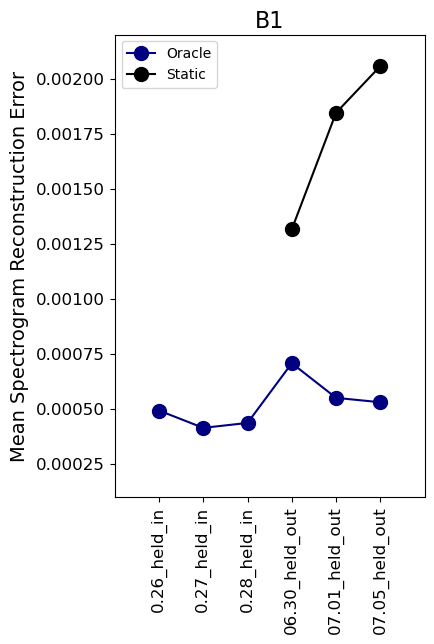

In [15]:
plt.figure(figsize=(4, 6))

# ORACLE
mean_within_day_errors = [np.mean(err) for err in within_day_errors]
x_coords = np.arange(0, len(mean_within_day_errors))
# Plotting points with markers, and connecting them with a line
plt.plot(x_coords, mean_within_day_errors, marker='o', linestyle='-', color='navy', markersize=10, label='Oracle')

# STATIC
mean_stabilization_errors = [np.mean(err) for err in stabilization_errors]
x_coords = np.arange(0, len(mean_stabilization_errors)) + 3
# Plotting points with markers, and connecting them with a line
plt.plot(x_coords, mean_stabilization_errors, marker='o', linestyle='-', color='black', markersize=10, label='Static')

x_ticks = ['0.26_held_in', '0.27_held_in', '0.28_held_in', '06.30_held_out', '07.01_held_out', '07.05_held_out']
plt.xticks(range(len(x_ticks)), x_ticks, fontsize=12, rotation=90) 
plt.yticks(fontsize=12) 
plt.ylabel('Mean Spectrogram Reconstruction Error', fontsize=14) 
plt.title('B1', fontsize=16) 
plt.xlim(-1, 6)  
plt.ylim(0.0001, 0.0022)  
plt.legend()
plt.show()